In [1]:
import numpy as np
import pandas as pd
from skimage import data
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


## EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [5]:
len([*df_train['annotation']])

73585

In [6]:
print("Number of Annotation =", df_train[df_train.id=='0030fd0e6378'].shape[0])

Number of Annotation = 395


In [7]:
print("Number of Annotation =", df_train[df_train.id=='03b27b381a5f'].shape[0])

Number of Annotation = 9


In [8]:
df_train.cell_type.unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [9]:
df_train[df_train.cell_type=='shsy5y'].sample_id.unique().shape[0]

118

### Bounding Box

In [10]:
def get_Bounding_Box(annotate):
    '''
    Returns [(x1,y1), (x2, y2))]
    '''
    shape = (704, 520)
    img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    s = annotate.split()
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    temp_img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    for start, end in zip(starts, ends):
        temp_img[start : end] = 1
    p2 = np.where(temp_img==1)[0][0]//704
    p4 = np.where(temp_img==1)[0][-1]//704
    temp_img = np.transpose(temp_img.reshape(520, 704)).reshape(shape[0] * shape[1])
    p1 = np.where(temp_img==1)[0][0]//520
    p3 = np.where(temp_img==1)[0][-1]//520        
    
    return ((p1, p2),(p3,p4))

In [11]:
annotate_list=[]
for annotate in [*df_train['annotation']]:
    annotate_list.append(get_Bounding_Box(annotate))

df_train['box'] = annotate_list
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,box
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,"((576, 167), (602, 196))"
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,"((359, 268), (373, 294))"
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,"((379, 246), (400, 275))"
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,"((296, 279), (326, 314))"
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,"((255, 238), (281, 260))"


In [12]:
def image_show(image, nrows=1, ncols=1, color_map='gray', title='default image'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))
    ax.imshow(image, cmap=color_map)
    ax.axis('off')
    return fig, ax

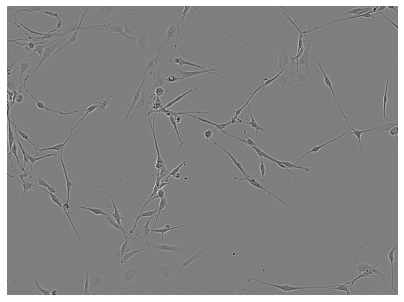

In [13]:
img = plt.imread('../input/sartorius-cell-instance-segmentation/train/0140b3c8f445.png')
image_show(img)
plt.show()

## Create annotation mask

In [14]:
def create_Mask(image_id, index=None):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)
    '''
    points_list=[]
    value=1
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    boxs = df_train[df_train["id"] == image_id]["box"].tolist()
    height = df_train[df_train["id"] == image_id]['height']
    height = int(height.unique())
    width = df_train[df_train["id"] == image_id]['width']
    width = int(width.unique())
    shape = (height, width)
    img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    for label, box in zip(labels, boxs):
        s = label.split()
        starts = list(map(lambda x: int(x) - 1, s[0::2]))
        lengths = list(map(int, s[1::2]))
        ends = [x + y for x, y in zip(starts, lengths)]
        for start, end in zip(starts, ends):
            img[start : end] = value
        points_list.append(box)
        value += 1
        
    mask = img.reshape(shape[0], shape[1])
    
    return mask, points_list

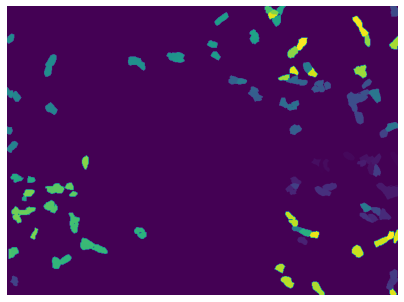

In [15]:
image_id = '1e7ac54a9422'
mask, points = create_Mask(image_id)
image_show(mask, color_map=None)
plt.show()

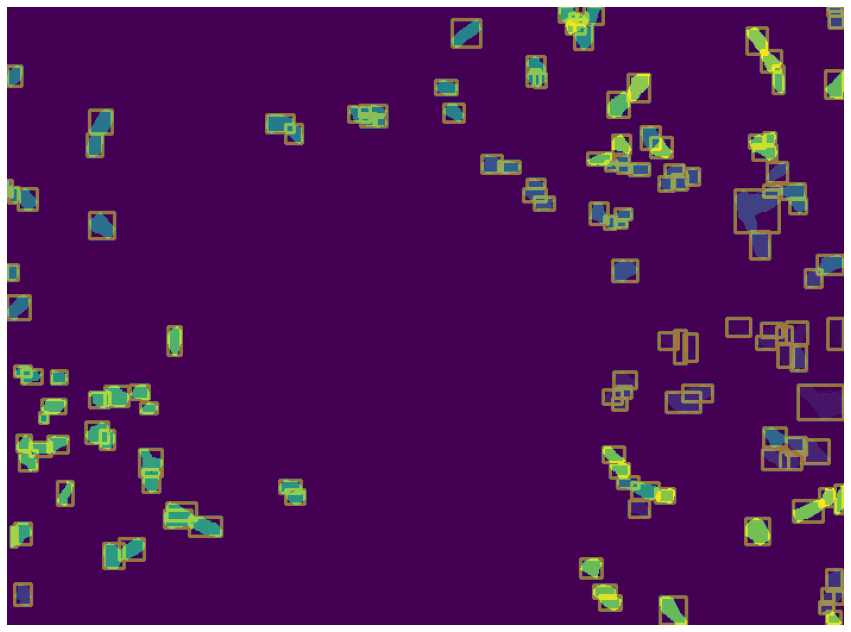

In [16]:
import cv2
image = mask.copy()
for point in points:
    image = cv2.rectangle(image, point[0], point[1], (225,0,0), 2)
    
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.imshow(image, alpha=0.5)

plt.axis('off')
plt.show()

## Filters

In [17]:
from skimage.filters import gaussian, median, unsharp_mask
from skimage import io, img_as_float, img_as_ubyte
from skimage.morphology import disk
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma, denoise_tv_chambolle

In [18]:
df_train.id.unique()[0]

'0030fd0e6378'

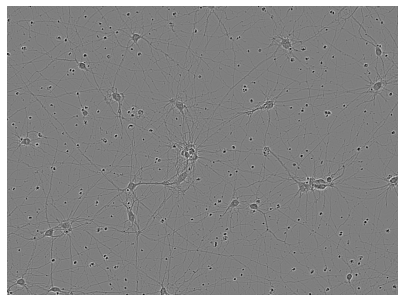

In [19]:
dir_path = "../input/sartorius-cell-instance-segmentation/train/"
img_id = df_train.id.unique()[30]
img = img_as_float(io.imread(dir_path+img_id+".png", as_gray=True))
image_show(img)
plt.show()

In [20]:
def image_2_show(image, filter_img, title, color_map='gray'):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    ax[0].imshow(image, cmap=color_map)
    ax[1].imshow(filter_img, cmap=color_map)
    ax[2].imshow(filter_img+image, cmap=color_map)
    ax[0].title.set_text('Default image')
    ax[1].title.set_text(title)
    ax[2].title.set_text(title+" and default image")
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    return fig, ax

**Gaussian Blur Denoising Filter**

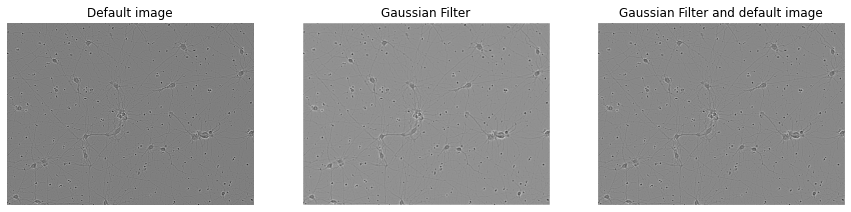

In [21]:
img_gaussian_filter = gaussian(img, sigma=1, mode='constant', cval=1.0)
image_2_show(img, img_gaussian_filter, title='Gaussian Filter')
plt.show()

### Median Filter

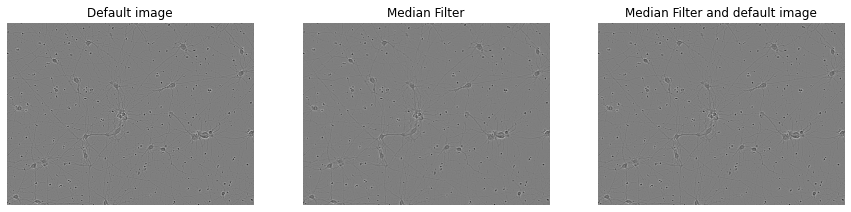

In [22]:
img_median_filter = median(img, disk(1), mode='constant', cval=0.0)
image_2_show(img, img_median_filter, title='Median Filter')
plt.show()

**Bilateral Filter**

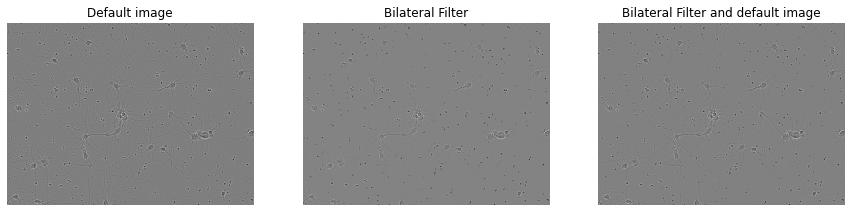

In [23]:
img_bilateral_filter = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15, multichannel=False)
image_2_show(img, img_bilateral_filter, title='Bilateral Filter')
plt.show()

**NLM Filter**

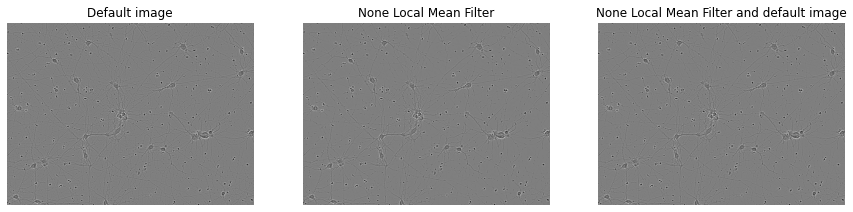

In [24]:
sigma_est = np.mean(estimate_sigma(img, multichannel=True))
denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True,
                               patch_size=5, patch_distance=3, multichannel=False)
image_2_show(img, denoise_img, title='None Local Mean Filter')
plt.show()

**Total Variation Filter**

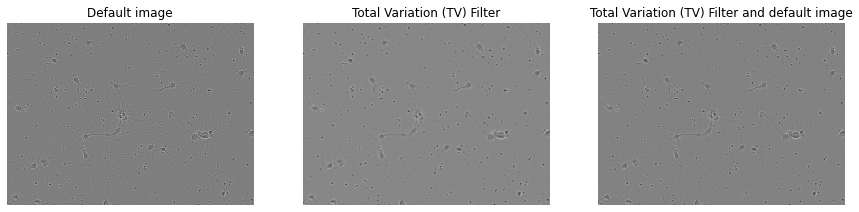

In [25]:
TV_img = denoise_tv_chambolle(img, weight=0.1, eps=0.0002, n_iter_max=200, multichannel=False)
image_2_show(img, TV_img, title='Total Variation (TV) Filter')
plt.show()

**Unsharp Filter**

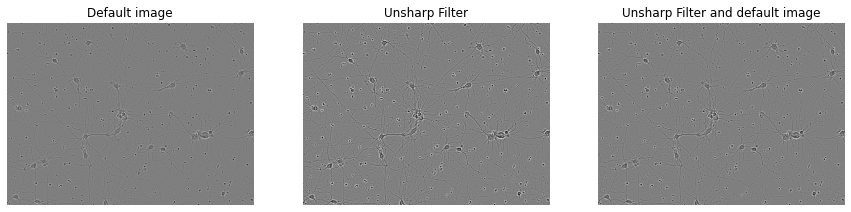

In [26]:
img_gaussian_filter = gaussian(img, sigma=1, mode='constant', cval=1.0)
unsharp_img = unsharp_mask(img, radius=5, amount=1.0)
image_2_show(img, unsharp_img, title='Unsharp Filter')
plt.show()

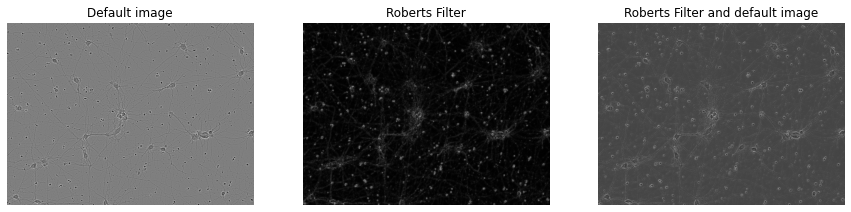

In [27]:
from skimage.filters import roberts, sobel, scharr, prewitt, farid
roberts_img = roberts(img)
sobel_img = sobel(img)
scharr_img = scharr(img)
prewitt_img = prewitt(img)
farid_img = farid(img)
image_2_show(img, roberts_img, title='Roberts Filter')
plt.show()

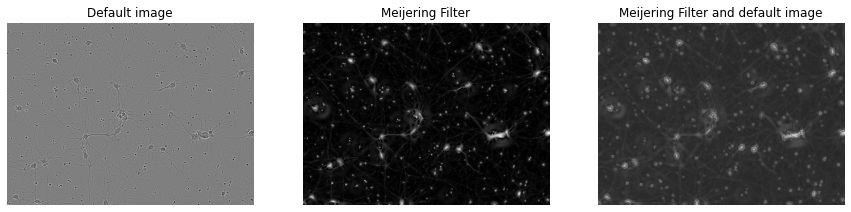

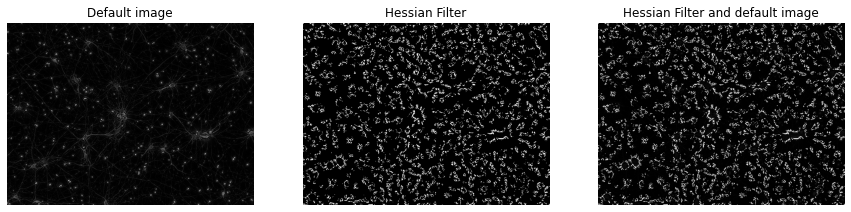

In [28]:
from skimage.filters import meijering, sato, frangi, hessian
meijering_img = meijering(img)
sato_img = sato(img)
frangi_img = frangi(img)
hessian_img = hessian(img)
mask = create_Mask(img_id)
image_2_show(img, meijering_img, title='Meijering Filter')
image_2_show(sato_img, hessian_img, title='Hessian Filter')
# image_2_show(frangi_img, mask, title='Mask Filter')

plt.show();

## Create Annotation

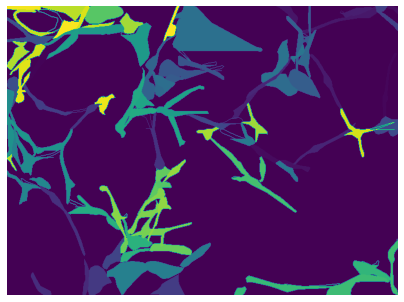

In [29]:
image_id = '0140b3c8f445'
mask, _= create_Mask(image_id, 1)
image_show(mask, color_map=None)
plt.show()

In [30]:
plt.imsave('mask.png', mask)

In [31]:
def mask_annotat(mask):
    img = mask.reshape(mask.shape[0]*mask.shape[1])
    annotation = []
    flag = 0
    for i in range(img.shape[0]):
        if flag==0 and img[i]==1:
            annotation.append(i)
            flag = 1
        elif flag==1 and img[i]==0:
            annotation.append(i - annotation[-1])
            flag=0
        else:
            pass

    return " ".join([str(x) for x in annotation])

In [32]:
mask_annotat(mask)

'36011 21 36711 11 37414 11 38116 12 38819 12 39522 12 40224 13 40927 13 41630 13 42332 14 43035 14 43738 14 44440 35 45143 35 45845 36 46548 36 47250 37 47952 38 48654 38 49355 40 50056 42 50758 43 51462 42 52165 42 52868 42 53572 40 54275 39 54978 38 55681 37 56384 36 57088 34 57791 34 58494 33 59198 31 59901 30 60605 28 61308 27 62012 25 62715 25 63419 23 64123 21 64826 20 65530 18 66233 17 66937 15 67640 15 68344 14 69047 14 69751 13 70454 14 71158 13 71861 13 72564 13 73268 12 73971 12 74674 12 75378 11 76081 12 76784 12 77488 11 78191 11 78894 11 79598 10 80301 11 81004 11 81708 10 82411 11 83115 10 83818 10 84522 10 85225 10 85929 10 86633 9 87337 8 88041 8 88744 8 89448 7 90152 7 90855 7 91559 6 92262 6 92965 5 93669 4 94373 3 95077 1'

## END :)